# Machine learning typically works better with more data to learn from

In [1]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np
import os, pandas, warnings
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

Seed = 72993
np.random.seed(Seed)
nJobs = 2

warnings.filterwarnings("ignore")

letters_1 = np.array(["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"])
letters_3 = np.array(['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HSE', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR'], dtype='<U3')


In [2]:
Hyperparameters = {"C": 100, "epsilon": 0.1, "gamma": "scale", "kernel": "rbf", "max_iter": -1, "tol": 0.0001, "verbose": 0}

model = SVR(**Hyperparameters)

L = 3

In [7]:
parameters = pandas.read_csv("Tripeptides_Judred.csv", index_col=0)


# This dataset stores peptides as 3-letter codes, so we need to translate to make it concur with the input parameters dataset
targets = pandas.read_csv("APs_Beyond.txt", index_col = 0, header=None, sep=" ")

def translate3to1(string):
    code = string.split("-")
    new_string = ""
    for AA in code:
        if AA == "HIS":
            AA = "HSE"
        index = np.where(letters_3 == AA)[0]
        new_string = new_string + str(letters_1[index][0])
    return "".join(new_string)

print("ALA-ALA-ARG-PRO-MET-GLY", "-->", translate3to1("ALA-ALA-ARG-PRO-MET-GLY"))

targets.index = [translate3to1(index) for index in targets.index]

#print(targets)

Forcefield = "2.1" # These are all martini 2.1

# Filter for tripeptides
targets = targets.reindex([x for x in targets.index if len(x) == 3])

#Make sure that parameters and their targets are indexed in the same order

parameters = parameters.reindex(targets.index)
print(parameters)
print(targets)



ALA-ALA-ARG-PRO-MET-GLY --> AARPMG
     Judred_NH2  Judred_MW  Judred_S  Judred_LogP WW  Judred_Z  Judred_MaxASA  \
AAA   -1.000000  -0.782750 -1.000000        0.291926  0.000000      -0.723757   
AAR   -0.333333  -0.343502 -1.000000        0.153209  0.333333      -0.189687   
AAN   -0.666667  -0.560700 -1.000000        0.271222  0.000000      -0.480663   
AAD   -1.000000  -0.555590 -1.000000       -0.138716 -0.333333      -0.488029   
AAC   -1.000000  -0.617271 -0.333333        0.314700  0.000000      -0.583794   
..          ...        ...       ...             ...       ...            ...   
VVS   -1.000000  -0.410653 -1.000000        0.648033  0.000000      -0.296501   
VVT   -1.000000  -0.338237 -1.000000        0.693582  0.000000      -0.233886   
VVW   -1.000000   0.101063 -1.000000        0.766046  0.000000       0.182320   
VVY   -1.000000  -0.017859 -1.000000        0.668737  0.000000       0.101289   
VVV   -1.000000  -0.348405 -1.000000        0.826087  0.000000      -0.226

In [4]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(parameters, targets, test_size=0.33, random_state=9876, shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=9876, shuffle=True)

In [8]:
# Define the hyperparameters we want to test
SVRrbf_param_grid = {
        "kernel": ["rbf"],
        "gamma": ["scale", "auto"],
        "C": [0.1, 1, 10, 100], 
        "epsilon": np.linspace(0.1, 1, 10), 
        "max_iter": [-1],
        "tol": [0.01, 0.001, 0.0001], 
        "verbose":[0]}

model = SVR()
HPO_model = GridSearchCV(estimator = model, param_grid = SVRrbf_param_grid, cv = 5, n_jobs = nJobs, verbose = True, error_score=0.0)
HPO_model.fit(X_train.values, y_train.values.reshape(-1))
print("\nBest params from grid search:")
print(HPO_model.best_params_)
SVMrbf_hyperparameters = HPO_model.best_params_


Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Best params from grid search:
{'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'tol': 0.01, 'verbose': 0}


Support vector machine RMSE: 0.2824311473058012


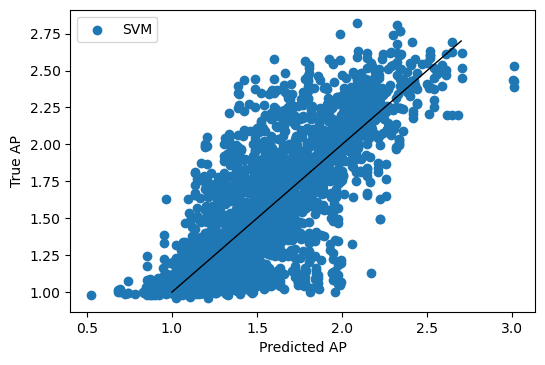

In [10]:
SVMmodel = SVR(**SVMrbf_hyperparameters)
SVMmodel.fit(X_train, y_train)
SVM_predictions = SVMmodel.predict(X_val)
SVM_rmse = mean_squared_error(y_val, SVM_predictions, squared=False)
print("Support vector machine RMSE:", SVM_rmse)

plt.scatter(SVM_predictions, y_val, label="SVM")

plt.plot([1,2.7], [1,2.7], lw=1, c="black")
plt.xlabel("Predicted AP")
plt.ylabel("True AP")
plt.gcf().set_dpi(100)
plt.legend()
plt.show()